In [1]:
cd ../..

/home/users/cdonoso/astromer/ASTROMER


In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os

from sklearn.metrics import r2_score, mean_squared_error

from core.astromer import get_ASTROMER, train, predict
from core.data  import pretraining_records

from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator


%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

In [14]:
exp_path = './weights/astromer_10022021/finetuning/ogle_f0/'
conf_file = os.path.join(exp_path, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)

In [15]:
conf_file = os.path.join(exp_path, 'conf.json')
with open(conf_file, 'r') as handle:
    conf_ft = json.load(handle)
conf_ft

{'max_obs': 200,
 'data': './data/records/ogle/fold_0/ogle',
 'p': './weights/astromer_10022021/finetuning/ogle_f0/finetuning/ogle_f0',
 'prefix': 'huge_2',
 'batch_size': 256,
 'epochs': 10000,
 'patience': 40,
 'layers': 2,
 'heads': 4,
 'head_dim': 256,
 'dff': 128,
 'dropout': 0.1,
 'base': 1000,
 'lr': 0.001,
 'use_leak': False,
 'no_train': False,
 'shuffle': False,
 'gpu': '1',
 'no_shuffle': False,
 'msk_frac': 0.5,
 'rnd_frac': 0.2,
 'same_frac': 0.2,
 'exp_date': '2021-11-18 23:16:57'}

In [16]:
test_batches = pretraining_records(os.path.join(conf_ft['data'], 'train'), 
                            256, 
                            max_obs=conf_ft['max_obs'],
                            msk_frac=conf_ft['msk_frac'],
                            rnd_frac=conf_ft['rnd_frac'],
                            same_frac=conf_ft['same_frac'],
                            shuffle=False,
                            sampling=False)

In [17]:
# sum([t['input'].shape[0] for t in test_batches])

In [18]:
ft_model = get_ASTROMER(num_layers=conf_ft['layers'],
                        d_model=conf_ft['head_dim'],
                        num_heads=conf_ft['heads'],
                        dff=conf_ft['dff'],
                        base=conf_ft['base'],
                        dropout=conf_ft['dropout'],
                        maxlen=conf_ft['max_obs'])
weights_path = '{}/weights'.format(exp_path)
ft_model.load_weights(weights_path)

In [19]:
result = predict(ft_model, test_batches, conf_ft)

prediction: 3792it [1:02:52,  1.01it/s]


In [22]:
%%time
masked_x_true = tf.ragged.boolean_mask(
    result['x_true'][...,0], tf.cast(result['mask'][...,0], dtype=tf.bool), name=None
)
masked_x_pred = tf.ragged.boolean_mask(
    result['x_pred'][...,0], tf.cast(result['mask'][...,0], dtype=tf.bool), name=None
)

CPU times: user 6.53 s, sys: 40.4 s, total: 46.9 s
Wall time: 3.66 s


In [24]:
%%time
r2_scores = tf.map_fn(lambda x: r2_score(x[0], x[1]), 
                      (masked_x_true, masked_x_pred), 
                      dtype=(tf.float32, tf.float32),
                      fn_output_signature=(tf.float32), 
                      parallel_iterations=8, infer_shape=False)

Cause: could not parse the source code of <function <lambda> at 0x7f31a7cfcb80>: no matching AST found
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 8min 37s, sys: 87.6 ms, total: 8min 37s
Wall time: 8min 39s


In [25]:
print('r2: {}\nmse: {}'.format(tf.reduce_mean(r2_scores), result['mse']))

r2: 0.809247612953186
mse: 0.021984534338116646


Text(0.52, 0.0, 'Number of Epochs')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Palatino


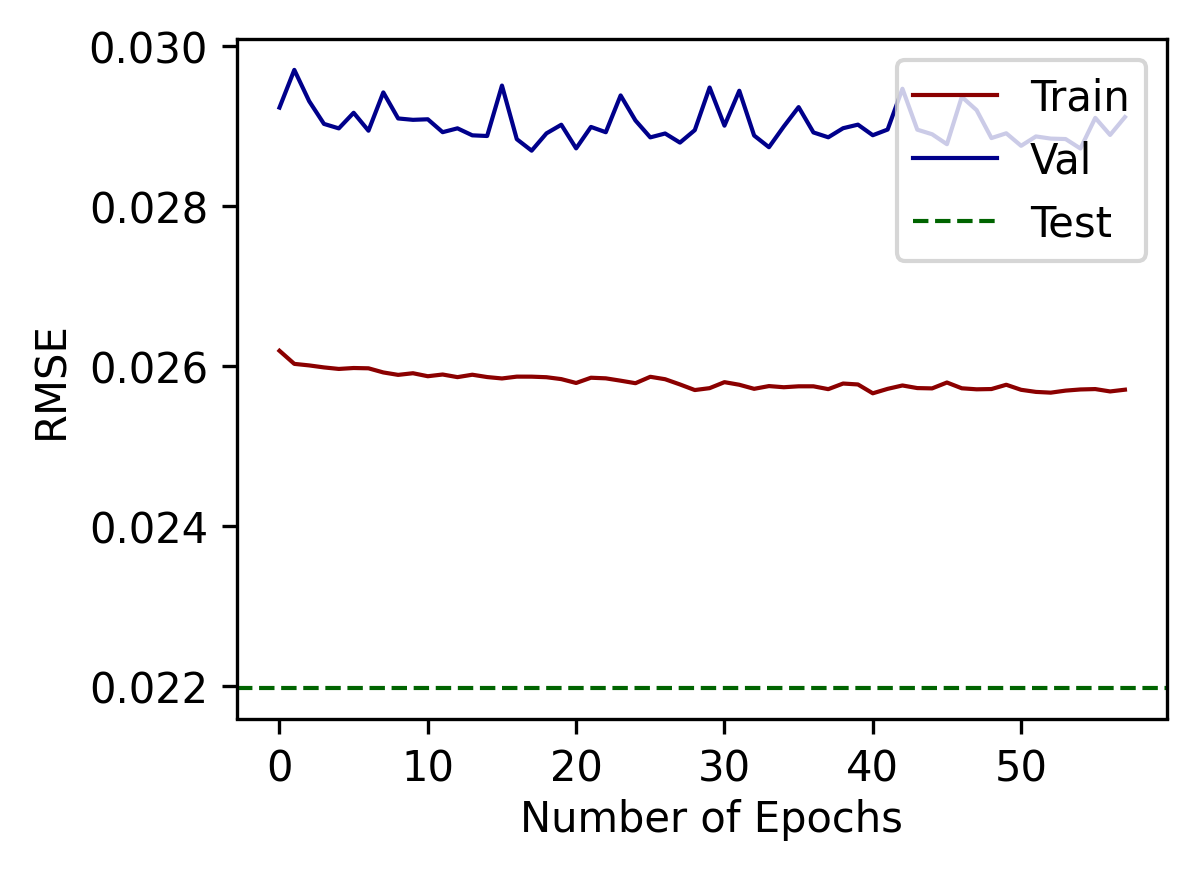

In [27]:
train_metrics = get_metrics(os.path.join(exp_path, 'logs', 'train'))
val_metrics = get_metrics(os.path.join(exp_path, 'logs', 'valid'))

fig, axes = plt.subplots(1, 1, figsize=(4,3), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=300)
for i, key in enumerate(val_metrics.keys()):
    
    train_values = np.array(train_metrics[key])
#     train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
#     vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes.plot(train_values, label='Train', color='darkred', linewidth=1)
    axes.plot(vaild_values, label='Val', color='darkblue', linewidth=1)
    axes.set_ylabel('RMSE')
        
axes.axhline(result['mse'], linestyle='--', linewidth=1, color='darkgreen', label='Test')
axes.legend(loc='upper right')
fig.text(0.52, 0.0, 'Number of Epochs', ha='center')
# fig.savefig('presentation/figures/machit_ft_lc.pdf', format='pdf' , bbox_inches='tight') #transparent=True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


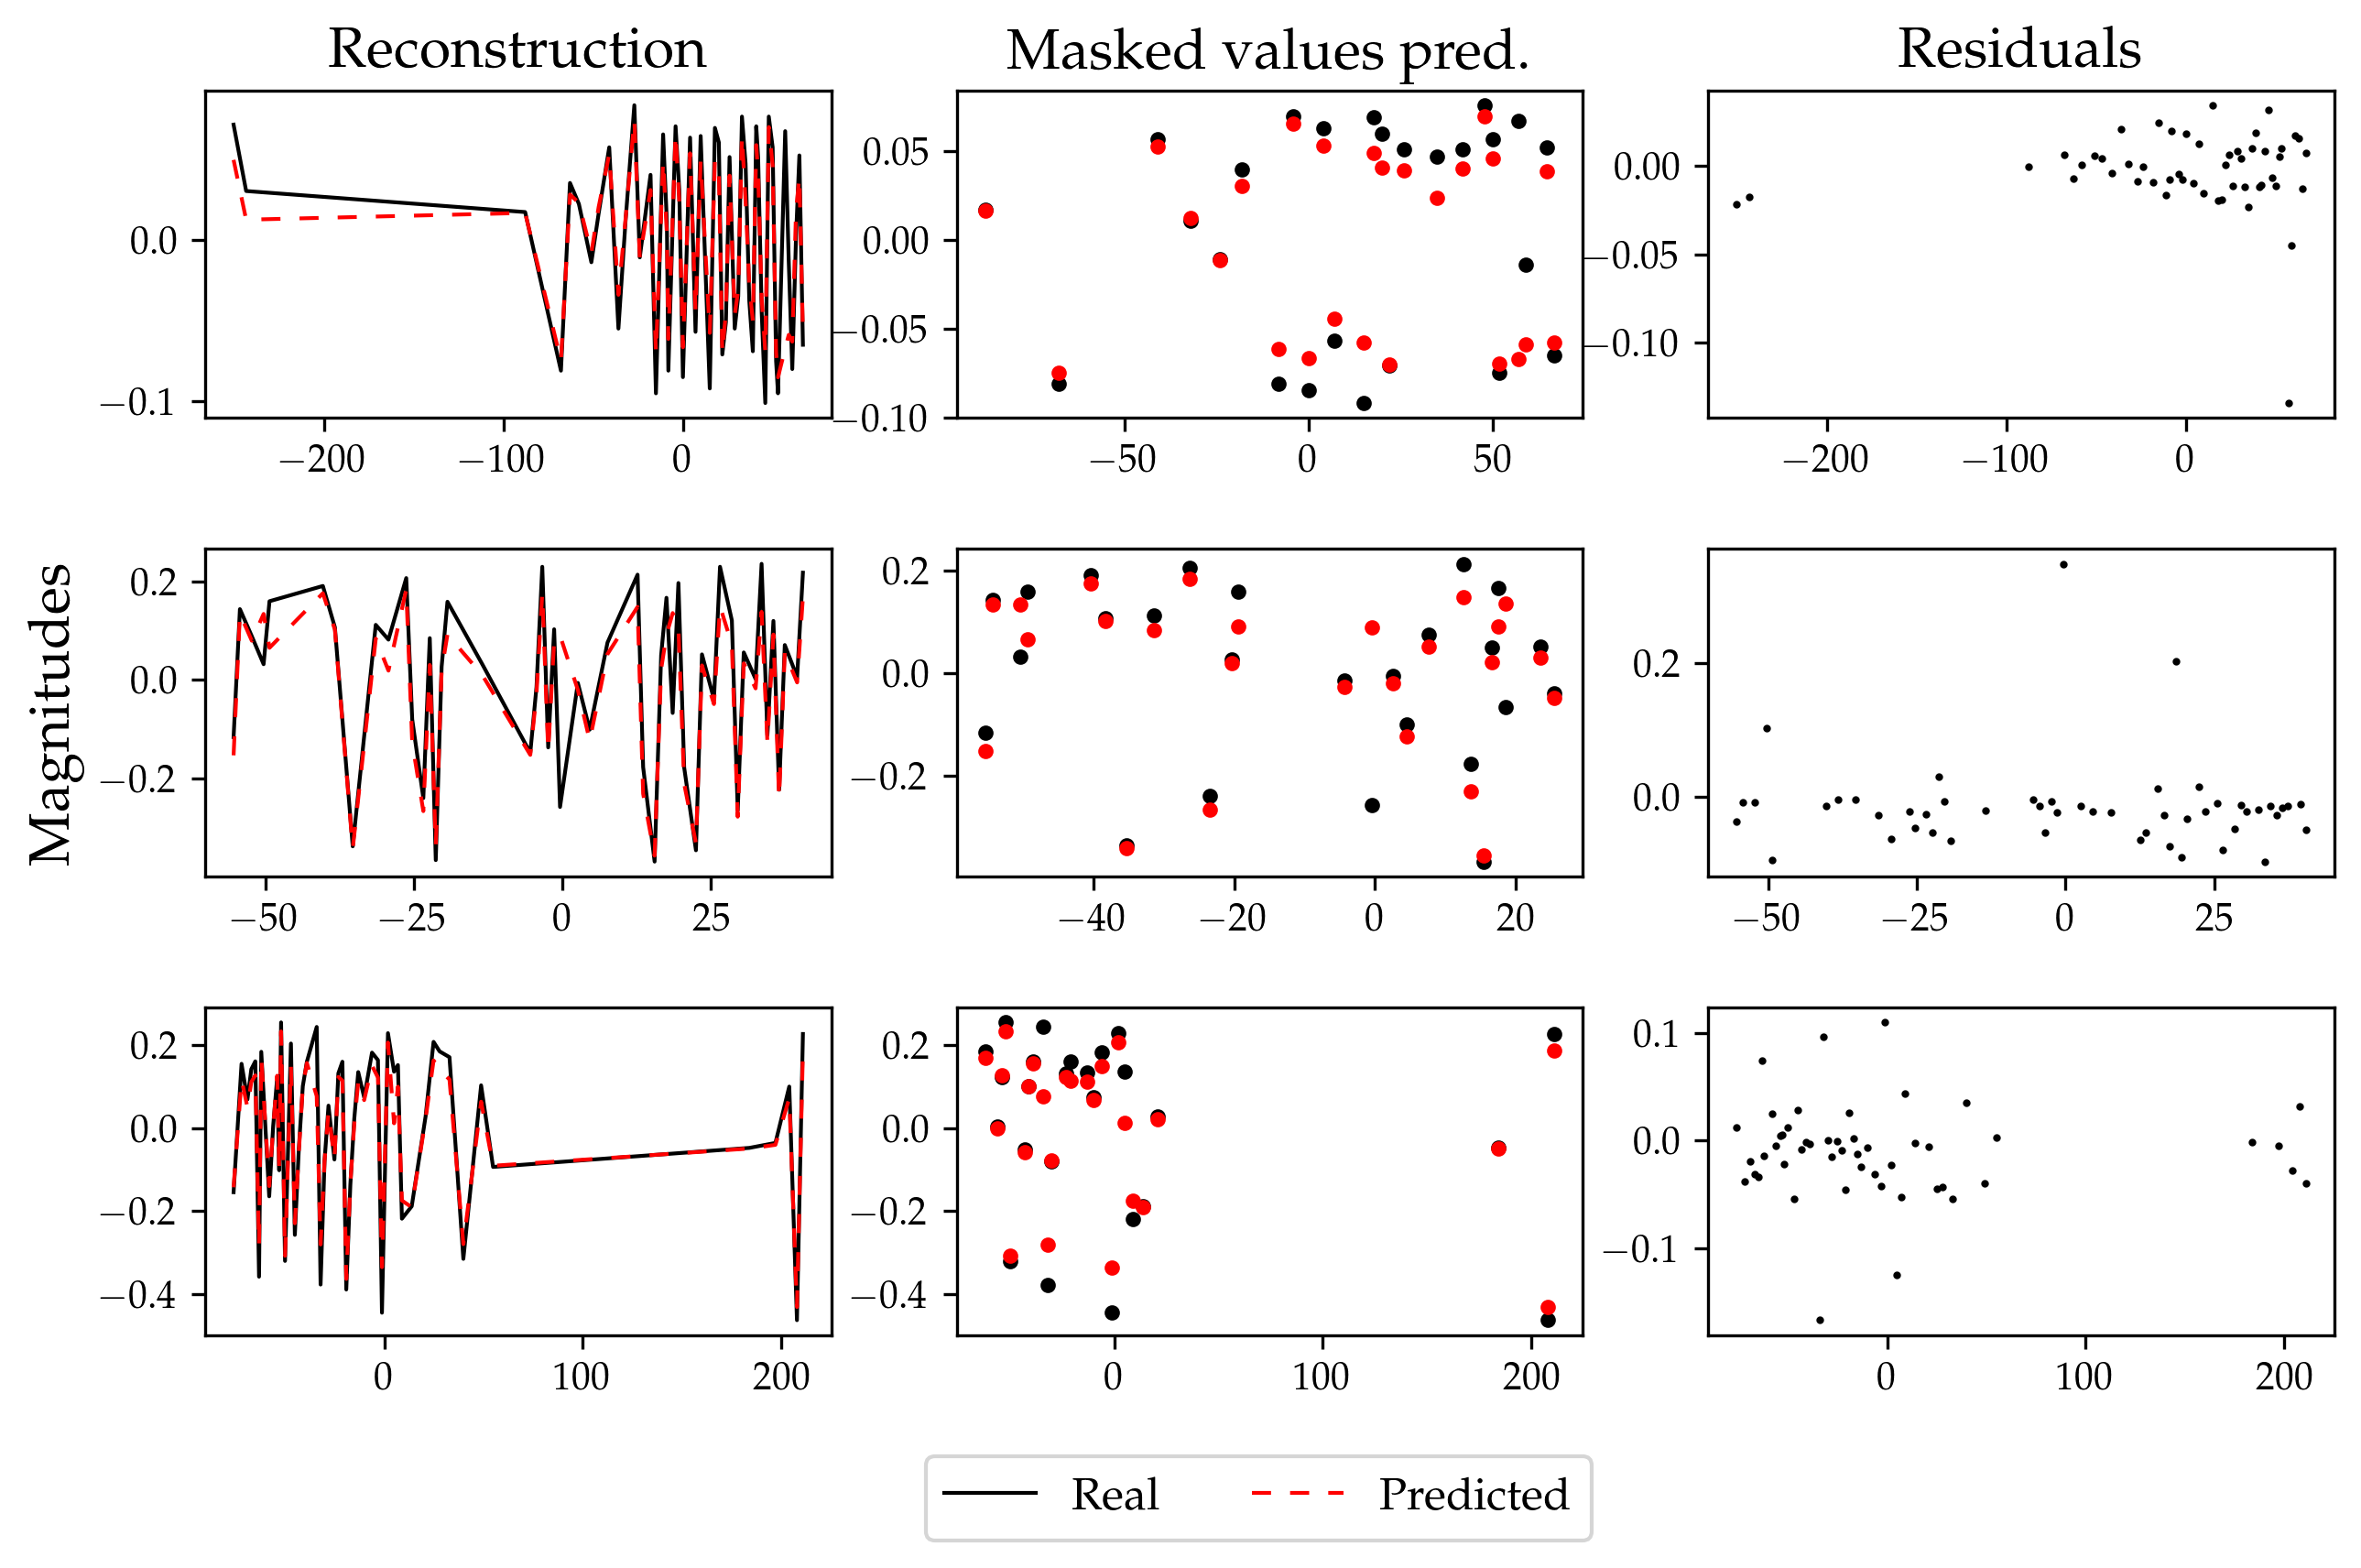

In [19]:
N = 3
fig, axes = plt.subplots(N, 3, dpi=300, figsize=(10,6),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},
                         sharey=False, sharex=False)

obs = conf['max_obs']//2

for i in range(N):

    times = result['time'][i]
    serie_pred = result['x_pred'][i]
    serie_true = result['x_true'][i]
    
    axes[i][0].plot(times, serie_true, marker='',linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(times, serie_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    
    if i == 1:
        axes[i][0].set_ylabel('Magnitudes', fontsize=15)
    
    
    true_mask = tf.boolean_mask(result['x_true'][i], result['mask'][i])
    pred_mask = tf.boolean_mask(result['x_pred'][i], result['mask'][i])
    time_mask = tf.boolean_mask(times, result['mask'][i])

    axes[i][1].plot(time_mask, true_mask, marker='.',linewidth=1, linestyle='', color='k', label='Real')
    axes[i][1].plot(time_mask, pred_mask, marker='.',linewidth=1, linestyle='', color='red', label='Predicted')

    # RESIDUALS
    residuals = serie_pred - serie_true
    axes[i][2].plot(times, residuals, '.', markersize=2, color='k')
    
    if i == 0:
        axes[i][2].set_title('Residuals', fontsize=15)
        axes[i][1].set_title('Masked values pred.', fontsize=15)
        axes[i][0].set_title('Reconstruction', fontsize=15)
    
axes[-1][0].legend(ncol=3, bbox_to_anchor = (2.25, -0.3), fontsize=12)
fig.tight_layout()
fig.savefig('presentation/figures/machito_ft_rec.pdf', format='pdf')

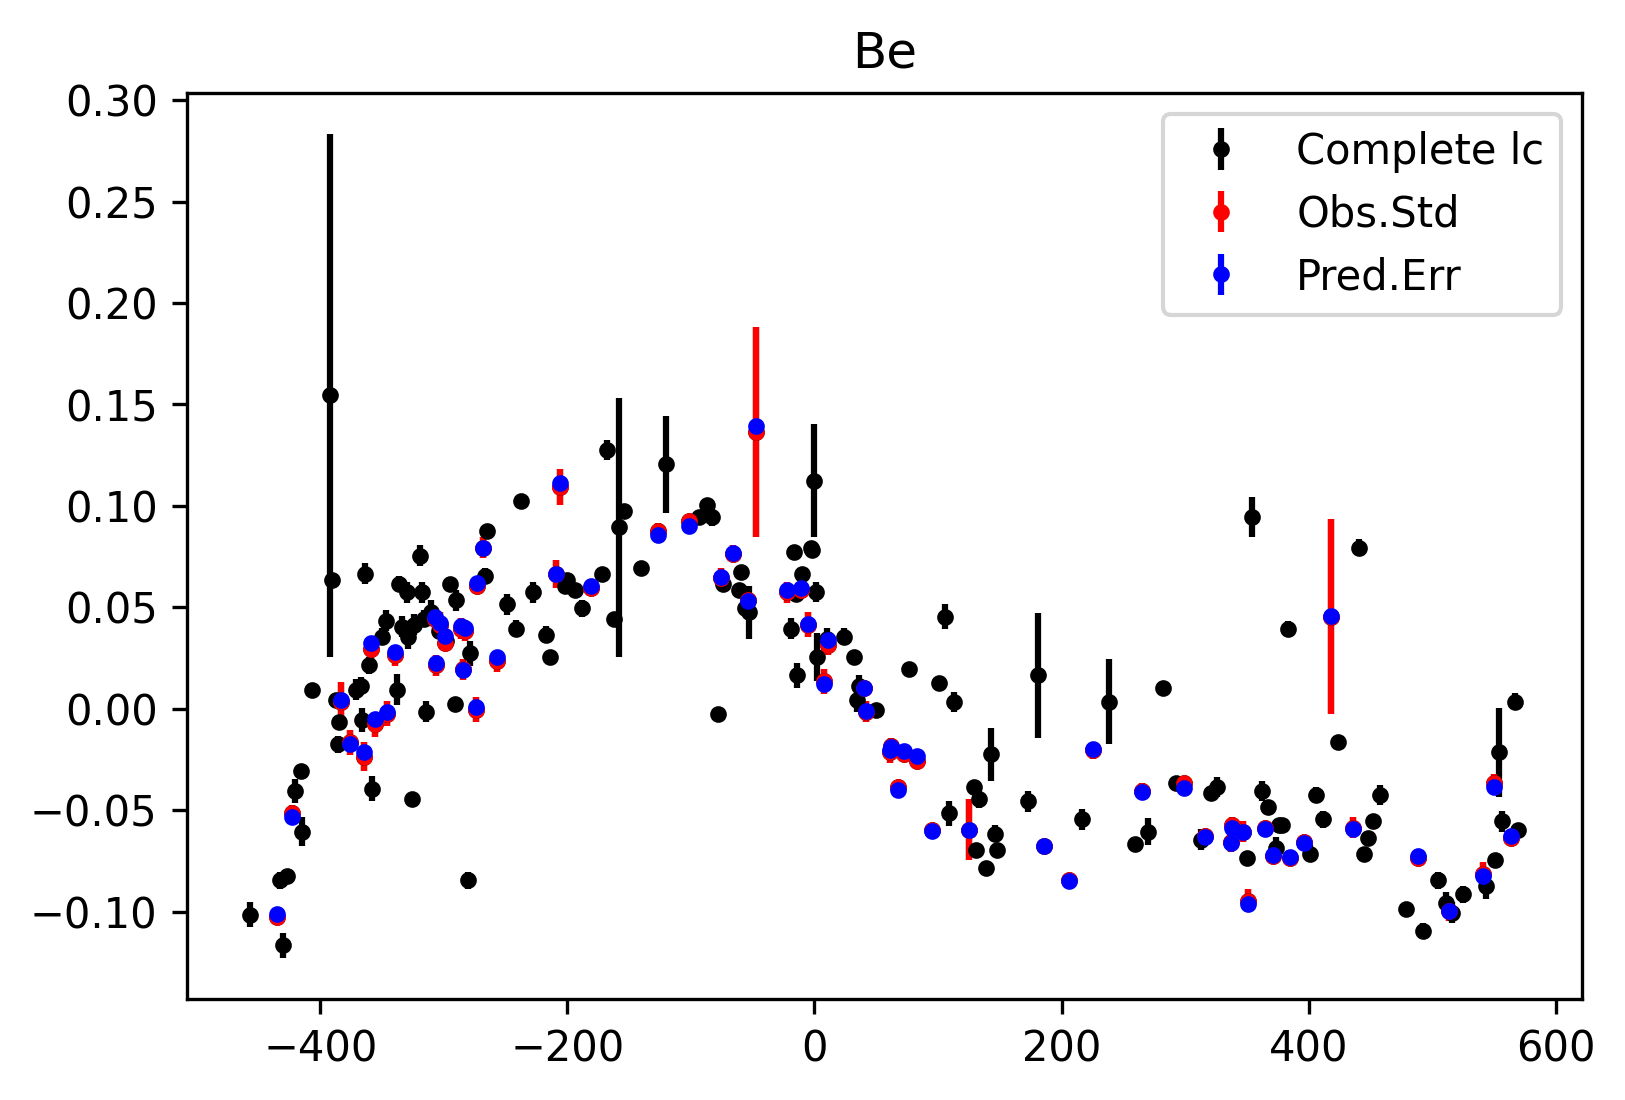

In [25]:
for step, batch in enumerate(test_batches):
    plt.figure(dpi=300)
    mse, x_pred, x_true = valid_step(astromer,
                                     batch,
                                     return_pred=True,
                                     normed=False)

    pred = x_pred[0]
    true = x_true[0]
    
    pred_err = true - pred
    
    errs = batch['obserr'][0]
    time = batch['times'][0]
    mask = batch['mask_in'][0]
    
    time = time[abs(errs)<200]
    mask = mask[abs(errs)<200]
    pred = pred[abs(errs)<200]
    true = true[abs(errs)<200]
    pred_err = pred_err[abs(errs)<200]
    errs = errs[abs(errs)<200]
    
    pred_masked = tf.boolean_mask(pred, mask)
    true_masked = tf.boolean_mask(true, mask)
    errs_masked = tf.boolean_mask(errs, mask)
    time_masked = tf.boolean_mask(time, mask)
    perr_masked = tf.boolean_mask(pred_err, mask)

    plt.errorbar(time, true, yerr=errs,
                 linestyle='', marker='.', color='k', label='Complete lc')
    
    plt.errorbar(time_masked, true_masked, yerr=errs_masked,
                 linestyle='', marker='.', color='r', label='Obs.Std')

    plt.errorbar(time_masked, pred_masked, yerr=perr_masked,
                 linestyle='', marker='.', color='b', label='Pred.Err')


    plt.legend()
    plt.title('{}'.format(class_names[batch['label'][0]]))
    break